# RAG System with Vector Database Comparison

This notebook implements a complete RAG (Retrieval Augmented Generation) system with:
- Vector database setup and indexing (ChromaDB and Milvus)
- ANN algorithm comparison (IVF, HNSW, FLAT)
- Semantic search with various similarity metrics
- Metadata filtering and hybrid search
- Performance benchmarking
- End-to-end RAG pipeline

## 1. Setup and Installation

In [69]:
# Install required packages
!pip install chromadb pymilvus sentence-transformers ollama langchain langchain-community langchain-ollama pandas numpy datasets python-dotenv tqdm matplotlib seaborn -q

In [70]:
import os
import time
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Dataset Preparation

We'll create a custom dataset about programming and technology topics (1000+ documents).

In [71]:
@dataclass
class Document:
    """Document class for storing text and metadata."""
    id: str
    text: str
    metadata: Dict[str, Any]
    embedding: Optional[List[float]] = None

class DatasetGenerator:
    """Generate a synthetic dataset about programming topics."""
    
    def __init__(self):
        self.categories = [
            "python", "javascript", "machine_learning", "web_development",
            "databases", "devops", "security", "cloud_computing",
            "data_science", "algorithms"
        ]
        
        self.templates = self._load_templates()
    
    def _load_templates(self) -> Dict[str, List[str]]:
        """Load document templates for each category."""
        templates = {
            "python": [
                "Python is a versatile programming language known for its {feature}. It excels in {use_case} and provides {benefit}. Key libraries include {libraries}.",
                "When working with Python, understanding {concept} is essential. This allows developers to {action} efficiently. Best practices include {practice}.",
                "Python's {module} module provides functionality for {purpose}. It supports {features} and is commonly used in {applications}.",
                "Advanced Python techniques like {technique} enable {capability}. This is particularly useful for {scenario} where {requirement} is needed.",
                "Python decorators are powerful tools for {decorator_use}. They wrap functions to add {functionality} without modifying the original code."
            ],
            "javascript": [
                "JavaScript enables {feature} in web applications. Modern frameworks like {framework} provide {benefit} for building {app_type}.",
                "Understanding {concept} in JavaScript is crucial for {purpose}. This enables developers to create {result} with {advantage}.",
                "The {api} API in JavaScript allows {functionality}. It's commonly used for {use_case} and supports {features}.",
                "JavaScript's async/await pattern simplifies {async_task}. Combined with {technology}, it enables {capability} in modern applications.",
                "ES6+ features like {feature} have transformed JavaScript development. They provide {benefit} and improve {aspect} of code."
            ],
            "machine_learning": [
                "Machine learning algorithm {algorithm} is used for {task}. It works by {mechanism} and achieves {performance} on {dataset_type} datasets.",
                "Neural networks with {architecture} excel at {task}. Training requires {requirement} and optimization using {optimizer}.",
                "Feature engineering for {domain} involves {technique}. This improves model {metric} by {improvement_method}.",
                "Transfer learning from {pretrained_model} enables {capability}. Fine-tuning on {task} requires {approach} for optimal results.",
                "Evaluating ML models requires understanding {metric}. Cross-validation with {strategy} ensures {benefit} and prevents {issue}."
            ],
            "web_development": [
                "Modern web development uses {technology} for {purpose}. This approach provides {benefit} and enables {feature}.",
                "RESTful APIs design principles include {principle}. Implementing {feature} ensures {benefit} for API consumers.",
                "Frontend frameworks like {framework} optimize {aspect}. They use {technique} for {purpose} and improve {metric}.",
                "Web security best practices include {practice}. Protecting against {vulnerability} requires {solution} implementation.",
                "Progressive Web Apps combine {feature1} and {feature2}. They provide {benefit} while maintaining {characteristic}."
            ],
            "databases": [
                "Database {db_type} excels at {use_case}. It provides {feature} and supports {capability} for {scenario}.",
                "Query optimization in {database} involves {technique}. Using {feature} improves {metric} by {factor}.",
                "Database indexing strategies for {scenario} include {strategy}. The {index_type} index provides {benefit} for {query_type} queries.",
                "ACID properties ensure {property} in databases. Transaction isolation levels like {level} prevent {issue}.",
                "NoSQL databases like {database} are designed for {use_case}. They offer {advantage} compared to {comparison}."
            ],
            "devops": [
                "CI/CD pipelines automate {process}. Using {tool} enables {benefit} and reduces {issue}.",
                "Container orchestration with {platform} manages {aspect}. It provides {feature} for {use_case}.",
                "Infrastructure as Code using {tool} ensures {benefit}. Configuration management becomes {characteristic}.",
                "Monitoring and observability with {tool} tracks {metric}. Alert systems detect {issue} and enable {response}.",
                "DevOps practices like {practice} improve {aspect}. Teams achieve {benefit} through {approach}."
            ],
            "security": [
                "Cybersecurity measures against {threat} include {solution}. Implementing {technique} protects {asset}.",
                "Authentication using {method} provides {level} security. Combined with {feature}, it prevents {attack}.",
                "Encryption algorithms like {algorithm} secure {data_type}. Key management requires {practice} for {compliance}.",
                "Security auditing involves {process}. Tools like {tool} identify {vulnerability} in {target}.",
                "Zero Trust architecture requires {principle}. Every {entity} must be {action} before {access}."
            ],
            "cloud_computing": [
                "Cloud service {service} provides {capability}. It enables {use_case} with {benefit} pricing model.",
                "Serverless computing with {platform} handles {workload}. Auto-scaling based on {trigger} optimizes {resource}.",
                "Cloud architecture pattern {pattern} addresses {challenge}. It provides {benefit} for {scenario}.",
                "Multi-cloud strategy using {providers} ensures {benefit}. Considerations include {factor} and {consideration}.",
                "Cloud cost optimization involves {technique}. Monitoring {metric} helps reduce {expense} by {amount}."
            ],
            "data_science": [
                "Data preprocessing involves {technique}. Handling {data_issue} requires {approach} for accurate {output}.",
                "Statistical analysis using {method} reveals {insight}. Hypothesis testing with {test} validates {claim}.",
                "Data visualization with {library} creates {chart_type}. Effective visualizations communicate {information}.",
                "Big data processing with {framework} handles {scale}. Distributed computing enables {capability}.",
                "A/B testing methodology requires {component}. Statistical significance at {level} ensures {validity}."
            ],
            "algorithms": [
                "Algorithm {algorithm} solves {problem} in O({complexity}) time. It uses {technique} for {optimization}.",
                "Data structure {structure} provides O({complexity}) for {operation}. It's ideal for {use_case}.",
                "Dynamic programming approach to {problem} reduces complexity from {initial} to {optimized}.",
                "Graph algorithm {algorithm} finds {result}. Applications include {application} and {use_case}.",
                "Sorting algorithm {algorithm} has {characteristic}. It performs best when {condition}."
            ]
        }
        return templates
    
    def _get_fill_values(self, category: str) -> Dict[str, List[str]]:
        """Get fill values for template placeholders by category."""
        fill_values = {
            "python": {
                "feature": ["clean syntax", "dynamic typing", "extensive standard library", "duck typing", "list comprehensions"],
                "use_case": ["data analysis", "web development", "automation", "machine learning", "scientific computing"],
                "benefit": ["rapid development", "code readability", "extensive ecosystem", "cross-platform compatibility"],
                "libraries": ["NumPy, Pandas, Matplotlib", "Django, Flask, FastAPI", "TensorFlow, PyTorch", "requests, beautifulsoup"],
                "concept": ["generators", "context managers", "decorators", "metaclasses", "descriptors"],
                "action": ["manage resources", "handle large datasets", "extend functionality", "create reusable code"],
                "practice": ["using virtual environments", "following PEP 8", "writing unit tests", "type hinting"],
                "module": ["asyncio", "collections", "itertools", "functools", "pathlib"],
                "purpose": ["asynchronous programming", "specialized containers", "efficient iteration", "functional programming"],
                "features": ["coroutines", "default dictionaries", "combinatorics", "higher-order functions"],
                "applications": ["network servers", "data processing", "algorithm implementation", "file handling"],
                "technique": ["metaclass programming", "monkey patching", "dependency injection", "aspect-oriented programming"],
                "capability": ["runtime class modification", "automatic logging", "loose coupling", "cross-cutting concerns"],
                "scenario": ["framework development", "debugging", "testing", "plugin systems"],
                "requirement": ["flexibility", "extensibility", "maintainability", "testability"],
                "decorator_use": ["logging", "caching", "authentication", "rate limiting", "validation"],
                "functionality": ["timing information", "memoization", "access control", "input validation"]
            },
            "javascript": {
                "feature": ["interactive UIs", "real-time updates", "client-side validation", "DOM manipulation"],
                "framework": ["React", "Vue.js", "Angular", "Svelte", "Next.js"],
                "benefit": ["component reusability", "virtual DOM", "state management", "server-side rendering"],
                "app_type": ["single-page applications", "progressive web apps", "mobile apps", "desktop applications"],
                "concept": ["closures", "prototypes", "event loop", "promises", "hoisting"],
                "purpose": ["managing scope", "object inheritance", "asynchronous operations", "error handling"],
                "result": ["responsive interfaces", "efficient code", "scalable applications", "maintainable systems"],
                "advantage": ["better performance", "cleaner code", "easier debugging", "improved UX"],
                "api": ["Fetch", "Web Storage", "WebSocket", "Service Worker", "Canvas"],
                "functionality": ["HTTP requests", "local data persistence", "real-time communication", "offline capabilities"],
                "use_case": ["API calls", "user preferences", "chat applications", "background sync"],
                "features": ["streaming", "IndexedDB", "binary data", "push notifications"],
                "async_task": ["API calls", "file operations", "database queries", "parallel processing"],
                "technology": ["Promise.all", "generators", "observables", "web workers"],
                "capability": ["non-blocking operations", "concurrent processing", "responsive UIs", "background tasks"],
                "aspect": ["readability", "maintainability", "performance", "developer experience"]
            },
            "machine_learning": {
                "algorithm": ["Random Forest", "XGBoost", "SVM", "k-NN", "Logistic Regression"],
                "task": ["classification", "regression", "clustering", "anomaly detection", "recommendation"],
                "mechanism": ["ensemble learning", "kernel tricks", "gradient boosting", "distance metrics"],
                "performance": ["high accuracy", "robust predictions", "fast inference", "interpretable results"],
                "dataset_type": ["tabular", "imbalanced", "high-dimensional", "time-series"],
                "architecture": ["CNN", "RNN", "Transformer", "GAN", "autoencoder"],
                "requirement": ["large datasets", "GPU resources", "careful hyperparameter tuning", "regularization"],
                "optimizer": ["Adam", "SGD", "RMSprop", "AdaGrad"],
                "domain": ["NLP", "computer vision", "time series", "tabular data"],
                "technique": ["normalization", "encoding", "dimensionality reduction", "feature selection"],
                "metric": ["accuracy", "F1-score", "AUC-ROC", "RMSE"],
                "improvement_method": ["capturing patterns", "reducing noise", "handling missing data", "creating interactions"],
                "pretrained_model": ["BERT", "ResNet", "GPT", "VGG", "EfficientNet"],
                "approach": ["gradual unfreezing", "learning rate scheduling", "data augmentation", "regularization"],
                "strategy": ["k-fold", "stratified", "time-series split", "leave-one-out"],
                "benefit": ["reliable estimates", "reduced variance", "better generalization"],
                "issue": ["overfitting", "data leakage", "selection bias"]
            },
            "web_development": {
                "technology": ["microservices", "GraphQL", "WebAssembly", "JAMstack", "Server Components"],
                "purpose": ["scalability", "flexible data fetching", "near-native performance", "static site generation"],
                "benefit": ["independent deployment", "reduced over-fetching", "fast execution", "improved SEO"],
                "feature": ["service discovery", "schema stitching", "memory safety", "edge computing"],
                "principle": ["statelessness", "resource naming", "HATEOAS", "versioning"],
                "framework": ["React", "Vue", "Angular", "Svelte"],
                "aspect": ["rendering", "state management", "routing", "code splitting"],
                "technique": ["virtual DOM", "reactivity", "lazy loading", "hydration"],
                "metric": ["Time to Interactive", "First Contentful Paint", "bundle size"],
                "practice": ["input validation", "HTTPS everywhere", "CSP headers", "secure cookies"],
                "vulnerability": ["XSS", "CSRF", "SQL injection", "clickjacking"],
                "solution": ["sanitization", "tokens", "parameterized queries", "frame options"],
                "feature1": ["offline support", "push notifications", "app-like experience"],
                "feature2": ["fast loading", "responsive design", "installability"],
                "characteristic": ["web accessibility", "cross-platform compatibility", "discoverability"]
            },
            "databases": {
                "db_type": ["PostgreSQL", "MongoDB", "Redis", "Elasticsearch", "Cassandra"],
                "use_case": ["complex queries", "document storage", "caching", "full-text search", "time-series data"],
                "feature": ["JSONB support", "flexible schema", "in-memory storage", "inverted indices", "wide-column storage"],
                "capability": ["full-text search", "horizontal scaling", "pub/sub", "aggregations", "tunable consistency"],
                "scenario": ["analytics workloads", "real-time applications", "session management", "log analysis"],
                "database": ["PostgreSQL", "MySQL", "MongoDB", "Cassandra"],
                "technique": ["query planning", "index optimization", "partitioning", "denormalization"],
                "factor": ["10x", "5x", "100x", "significant margin"],
                "strategy": ["B-tree indexes", "covering indexes", "partial indexes", "composite indexes"],
                "index_type": ["B-tree", "Hash", "GiST", "GIN"],
                "query_type": ["range", "equality", "spatial", "full-text"],
                "property": ["atomicity", "consistency", "isolation", "durability"],
                "level": ["Read Committed", "Repeatable Read", "Serializable"],
                "issue": ["dirty reads", "phantom reads", "lost updates"],
                "advantage": ["horizontal scalability", "flexible schema", "high availability"],
                "comparison": ["traditional RDBMS", "single-node databases", "rigid schemas"]
            },
            "devops": {
                "process": ["build and deployment", "testing", "security scanning", "infrastructure provisioning"],
                "tool": ["Jenkins", "GitHub Actions", "Terraform", "Prometheus", "Ansible"],
                "benefit": ["faster releases", "consistent environments", "early bug detection", "infrastructure visibility"],
                "issue": ["manual errors", "deployment failures", "configuration drift", "performance issues"],
                "platform": ["Kubernetes", "Docker Swarm", "ECS", "Nomad"],
                "aspect": ["container lifecycle", "service discovery", "load balancing", "auto-scaling"],
                "feature": ["rolling updates", "health checks", "resource limits", "secrets management"],
                "use_case": ["microservices", "batch jobs", "stateful applications", "edge computing"],
                "characteristic": ["reproducible", "version controlled", "auditable", "automated"],
                "metric": ["response times", "error rates", "resource utilization", "throughput"],
                "response": ["auto-remediation", "on-call notification", "scaling actions"],
                "practice": ["continuous integration", "infrastructure as code", "GitOps", "chaos engineering"],
                "approach": ["automation", "collaboration", "measurement", "sharing"]
            },
            "security": {
                "threat": ["SQL injection", "XSS attacks", "DDoS", "phishing", "ransomware"],
                "solution": ["parameterized queries", "input sanitization", "rate limiting", "security training", "backups"],
                "technique": ["defense in depth", "least privilege", "security headers", "encryption at rest"],
                "asset": ["user data", "API endpoints", "database", "file systems"],
                "method": ["OAuth 2.0", "JWT tokens", "multi-factor", "biometrics", "SSO"],
                "level": ["enterprise-grade", "high", "military-grade", "compliant"],
                "feature": ["refresh tokens", "device fingerprinting", "risk-based auth"],
                "attack": ["session hijacking", "brute force", "credential stuffing", "man-in-the-middle"],
                "algorithm": ["AES-256", "RSA", "ChaCha20", "Argon2"],
                "data_type": ["data at rest", "data in transit", "passwords", "PII"],
                "practice": ["key rotation", "HSM usage", "secure key storage"],
                "compliance": ["GDPR", "HIPAA", "PCI-DSS", "SOC 2"],
                "process": ["penetration testing", "code review", "vulnerability scanning", "threat modeling"],
                "vulnerability": ["outdated dependencies", "misconfigurations", "exposed secrets"],
                "target": ["applications", "networks", "containers", "cloud infrastructure"],
                "principle": ["never trust, always verify", "micro-segmentation", "continuous validation"],
                "entity": ["user", "device", "application", "network flow"],
                "action": ["authenticated", "authorized", "validated"],
                "access": ["granting access", "allowing connection", "permitting action"]
            },
            "cloud_computing": {
                "service": ["EC2", "Lambda", "S3", "RDS", "CloudFront"],
                "capability": ["scalable compute", "serverless execution", "object storage", "managed databases", "CDN"],
                "use_case": ["web hosting", "event processing", "data lakes", "OLTP workloads", "static assets"],
                "benefit": ["pay-per-use", "per-invocation", "durability", "automated backups", "global distribution"],
                "platform": ["AWS Lambda", "Azure Functions", "Google Cloud Functions", "Cloudflare Workers"],
                "workload": ["API backends", "data processing", "scheduled tasks", "webhooks"],
                "trigger": ["HTTP requests", "queue messages", "file uploads", "schedules"],
                "resource": ["costs", "cold starts", "memory usage", "execution time"],
                "pattern": ["event sourcing", "CQRS", "saga", "strangler fig"],
                "challenge": ["data consistency", "read/write separation", "distributed transactions", "legacy migration"],
                "providers": ["AWS and Azure", "GCP and AWS", "multi-cloud"],
                "factor": ["data sovereignty", "vendor lock-in", "cost optimization"],
                "consideration": ["networking complexity", "skill requirements", "tooling differences"],
                "technique": ["right-sizing", "reserved instances", "spot instances", "auto-scaling"],
                "metric": ["unused resources", "data transfer costs", "storage tiers"],
                "expense": ["compute costs", "storage costs", "network egress"],
                "amount": ["30-50%", "significant amounts", "up to 70%"]
            },
            "data_science": {
                "technique": ["normalization", "imputation", "encoding", "outlier detection", "feature scaling"],
                "data_issue": ["missing values", "outliers", "categorical variables", "skewed distributions"],
                "approach": ["mean/median imputation", "IQR method", "one-hot encoding", "log transformation"],
                "output": ["analysis", "model training", "predictions", "insights"],
                "method": ["regression analysis", "hypothesis testing", "ANOVA", "correlation analysis"],
                "insight": ["relationships between variables", "significant differences", "trends", "patterns"],
                "test": ["t-test", "chi-square", "Mann-Whitney U", "Kolmogorov-Smirnov"],
                "claim": ["statistical significance", "effect size", "confidence intervals"],
                "library": ["Matplotlib", "Seaborn", "Plotly", "Altair"],
                "chart_type": ["scatter plots", "heatmaps", "interactive dashboards", "time series charts"],
                "information": ["patterns", "outliers", "distributions", "relationships"],
                "framework": ["Spark", "Dask", "Flink", "Beam"],
                "scale": ["petabyte-scale data", "streaming data", "distributed datasets"],
                "capability": ["parallel processing", "real-time analytics", "fault tolerance"],
                "component": ["proper sample size", "randomization", "control groups", "clear metrics"],
                "level": ["p < 0.05", "95% confidence", "p < 0.01"],
                "validity": ["reliable conclusions", "actionable insights", "business decisions"]
            },
            "algorithms": {
                "algorithm": ["QuickSort", "Dijkstra's", "A*", "Binary Search", "Merge Sort"],
                "problem": ["sorting", "shortest path", "pathfinding", "searching", "divide and conquer"],
                "complexity": ["n log n", "V + E log V", "b^d", "log n", "n log n"],
                "technique": ["partitioning", "relaxation", "heuristics", "divide and conquer"],
                "optimization": ["in-place sorting", "early termination", "pruning", "memoization"],
                "structure": ["Hash Table", "Binary Search Tree", "Heap", "Trie", "Graph"],
                "operation": ["lookup", "insertion/deletion", "extract-min", "prefix search", "traversal"],
                "use_case": ["caching", "ordered data", "priority queues", "autocomplete", "network routing"],
                "initial": ["O(2^n)", "O(n!)", "O(n^2)", "exponential"],
                "optimized": ["O(n*W)", "O(n^2)", "O(n log n)", "polynomial"],
                "result": ["shortest paths", "minimum spanning tree", "strongly connected components", "topological order"],
                "application": ["GPS navigation", "network design", "dependency resolution", "scheduling"],
                "characteristic": ["stability", "adaptiveness", "in-place operation", "cache efficiency"],
                "condition": ["data is nearly sorted", "memory is limited", "stability matters", "parallel execution is available"]
            }
        }
        return fill_values.get(category, {})
    
    def generate_document(self, doc_id: int, category: str) -> Document:
        """Generate a single document."""
        import random
        
        template = random.choice(self.templates[category])
        fill_values = self._get_fill_values(category)
        
        # Fill template with random values
        text = template
        for key, values in fill_values.items():
            placeholder = "{" + key + "}"
            if placeholder in text:
                text = text.replace(placeholder, random.choice(values), 1)
        
        difficulty = random.choice(["beginner", "intermediate", "advanced"])
        year = random.randint(2020, 2024)
        
        return Document(
            id=f"doc_{doc_id}",
            text=text,
            metadata={
                "category": category,
                "difficulty": difficulty,
                "year": year,
                "word_count": len(text.split())
            }
        )
    
    def generate_dataset(self, num_documents: int = 1200) -> List[Document]:
        """Generate a dataset with specified number of documents."""
        import random
        random.seed(42)  # For reproducibility
        
        documents = []
        docs_per_category = num_documents // len(self.categories)
        
        for category in self.categories:
            for i in range(docs_per_category):
                doc_id = len(documents)
                doc = self.generate_document(doc_id, category)
                documents.append(doc)
        
        # Shuffle documents
        random.shuffle(documents)
        
        return documents

# Generate dataset
generator = DatasetGenerator()
documents = generator.generate_dataset(1200)

print(f"Generated {len(documents)} documents")
print(f"\nSample document:")
print(f"ID: {documents[0].id}")
print(f"Text: {documents[0].text}")
print(f"Metadata: {documents[0].metadata}")

Generated 1200 documents

Sample document:
ID: doc_313
Text: Feature engineering for time series involves dimensionality reduction. This improves model accuracy by capturing patterns.
Metadata: {'category': 'machine_learning', 'difficulty': 'advanced', 'year': 2024, 'word_count': 15}


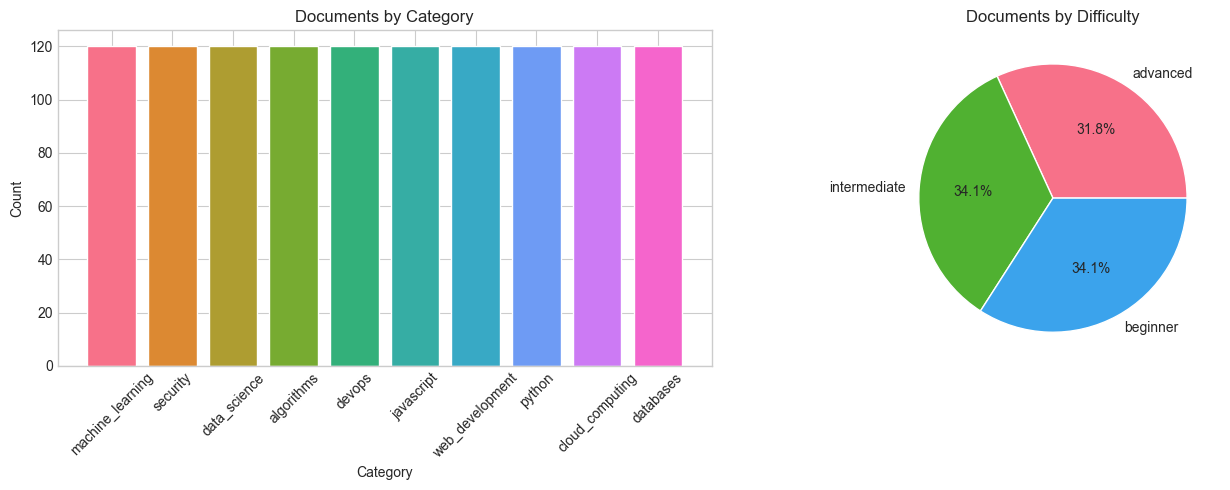

In [72]:
# Analyze dataset distribution
category_counts = defaultdict(int)
difficulty_counts = defaultdict(int)

for doc in documents:
    category_counts[doc.metadata['category']] += 1
    difficulty_counts[doc.metadata['difficulty']] += 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Category distribution
categories = list(category_counts.keys())
counts = list(category_counts.values())
axes[0].bar(categories, counts, color=sns.color_palette('husl', len(categories)))
axes[0].set_title('Documents by Category', fontsize=12)
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Difficulty distribution
difficulties = list(difficulty_counts.keys())
diff_counts = list(difficulty_counts.values())
axes[1].pie(diff_counts, labels=difficulties, autopct='%1.1f%%', colors=sns.color_palette('husl', 3))
axes[1].set_title('Documents by Difficulty', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Embedding Generation

We'll use sentence-transformers for creating document embeddings.

In [73]:
from sentence_transformers import SentenceTransformer

class EmbeddingGenerator:
    """Generate embeddings using sentence-transformers."""
    
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)
        self.embedding_dim = self.model.get_sentence_embedding_dimension()
        print(f"Loaded model: {model_name}")
        print(f"Embedding dimension: {self.embedding_dim}")
    
    def generate_embeddings(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        """Generate embeddings for a list of texts."""
        embeddings = self.model.encode(
            texts, 
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings
    
    def generate_query_embedding(self, query: str) -> np.ndarray:
        """Generate embedding for a single query."""
        return self.model.encode(query, convert_to_numpy=True)

# Initialize embedding generator
embedding_gen = EmbeddingGenerator()

# Generate embeddings for all documents
texts = [doc.text for doc in documents]
embeddings = embedding_gen.generate_embeddings(texts)

# Store embeddings in documents
for doc, emb in zip(documents, embeddings):
    doc.embedding = emb.tolist()

print(f"\nGenerated embeddings shape: {embeddings.shape}")

Loaded model: all-MiniLM-L6-v2
Embedding dimension: 384


Batches:   0%|          | 0/38 [00:00<?, ?it/s]


Generated embeddings shape: (1200, 384)


## 4. Vector Database Implementation - ChromaDB

### 4.1 ChromaDB Setup and Configuration

In [74]:
import chromadb
from chromadb.config import Settings

class ChromaDBManager:
    """Manager for ChromaDB operations."""
    
    def __init__(self, persist_directory: str = "./chroma_db"):
        """
        Initialize ChromaDB with configuration.
        
        ChromaDB Key Configuration Parameters:
        - persist_directory: Where to store the database
        - anonymized_telemetry: Disable telemetry for privacy
        - allow_reset: Allow database reset
        """
        self.client = chromadb.PersistentClient(
            path=persist_directory,
            settings=Settings(
                anonymized_telemetry=False,
                allow_reset=True
            )
        )
        self.collection = None
        print(f"ChromaDB initialized at: {persist_directory}")
    
    def create_collection(self, name: str, distance_metric: str = "cosine") -> None:
        """
        Create a collection with specified distance metric.
        
        Distance Metrics in ChromaDB:
        - 'cosine': Cosine similarity (default, good for semantic similarity)
        - 'l2': Euclidean distance (good for absolute distances)
        - 'ip': Inner product (good for normalized vectors)
        """
        # Delete existing collection if it exists
        try:
            self.client.delete_collection(name)
        except:
            pass
        
        self.collection = self.client.create_collection(
            name=name,
            metadata={"hnsw:space": distance_metric}  # ChromaDB uses HNSW internally
        )
        print(f"Created collection '{name}' with {distance_metric} distance metric")
    
    def add_documents(self, documents: List[Document], batch_size: int = 100) -> float:
        """Add documents to the collection."""
        start_time = time.time()
        
        for i in tqdm(range(0, len(documents), batch_size), desc="Indexing documents"):
            batch = documents[i:i+batch_size]
            
            self.collection.add(
                ids=[doc.id for doc in batch],
                embeddings=[doc.embedding for doc in batch],
                documents=[doc.text for doc in batch],
                metadatas=[doc.metadata for doc in batch]
            )
        
        indexing_time = time.time() - start_time
        print(f"Indexed {len(documents)} documents in {indexing_time:.2f}s")
        return indexing_time
    
    def search(self, query_embedding: List[float], top_k: int = 5, 
               where: Optional[Dict] = None, where_document: Optional[Dict] = None) -> Tuple[List[Dict], float]:
        """
        Search for similar documents.
        
        Parameters:
        - query_embedding: Vector to search for
        - top_k: Number of results to return
        - where: Metadata filter (e.g., {"category": "python"})
        - where_document: Document content filter
        """
        start_time = time.time()
        
        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=top_k,
            where=where,
            where_document=where_document,
            include=["documents", "metadatas", "distances"]
        )
        
        search_time = time.time() - start_time
        
        # Format results
        formatted_results = []
        for i in range(len(results['ids'][0])):
            formatted_results.append({
                'id': results['ids'][0][i],
                'document': results['documents'][0][i],
                'metadata': results['metadatas'][0][i],
                'distance': results['distances'][0][i]
            })
        
        return formatted_results, search_time
    
    def batch_search(self, query_embeddings: List[List[float]], top_k: int = 5) -> Tuple[List[List[Dict]], float]:
        """Perform batch search for multiple queries."""
        start_time = time.time()
        
        results = self.collection.query(
            query_embeddings=query_embeddings,
            n_results=top_k,
            include=["documents", "metadatas", "distances"]
        )
        
        search_time = time.time() - start_time
        
        # Format results for each query
        all_results = []
        for q_idx in range(len(query_embeddings)):
            query_results = []
            for i in range(len(results['ids'][q_idx])):
                query_results.append({
                    'id': results['ids'][q_idx][i],
                    'document': results['documents'][q_idx][i],
                    'metadata': results['metadatas'][q_idx][i],
                    'distance': results['distances'][q_idx][i]
                })
            all_results.append(query_results)
        
        return all_results, search_time

# Initialize ChromaDB
chroma_manager = ChromaDBManager()
chroma_manager.create_collection("tech_documents", distance_metric="cosine")

# Index documents
indexing_time = chroma_manager.add_documents(documents)

ChromaDB initialized at: ./chroma_db
Created collection 'tech_documents' with cosine distance metric


Indexing documents: 100%|██████████| 12/12 [00:00<00:00, 21.44it/s]

Indexed 1200 documents in 0.56s


### 4.2 Basic Search Examples

In [75]:
# Test queries
test_queries = [
    "How to optimize database performance?",
    "What are the best practices for Python web development?",
    "Explain machine learning model training",
    "How to secure web applications?",
    "What is containerization and Kubernetes?"
]

print("=" * 80)
print("SEMANTIC SEARCH RESULTS")
print("=" * 80)

for query in test_queries:
    query_embedding = embedding_gen.generate_query_embedding(query)
    results, search_time = chroma_manager.search(query_embedding.tolist(), top_k=3)
    
    print(f"\nQuery: '{query}'")
    print(f"Search time: {search_time*1000:.2f}ms")
    print("-" * 40)
    
    for i, result in enumerate(results, 1):
        print(f"  {i}. [{result['metadata']['category']}] (dist: {result['distance']:.4f})")
        print(f"     {result['document'][:100]}...")

SEMANTIC SEARCH RESULTS

Query: 'How to optimize database performance?'
Search time: 13.53ms
----------------------------------------
  1. [databases] (dist: 0.5012)
     Query optimization in MySQL involves partitioning. Using flexible schema improves {metric} by signif...
  2. [databases] (dist: 0.5045)
     Query optimization in MySQL involves partitioning. Using wide-column storage improves {metric} by 5x...
  3. [databases] (dist: 0.5108)
     Query optimization in PostgreSQL involves index optimization. Using in-memory storage improves {metr...

Query: 'What are the best practices for Python web development?'
Search time: 1.00ms
----------------------------------------
  1. [python] (dist: 0.3118)
     Python is a versatile programming language known for its clean syntax. It excels in web development ...
  2. [python] (dist: 0.3644)
     Python is a versatile programming language known for its dynamic typing. It excels in web developmen...
  3. [python] (dist: 0.3832)
     Python

### 4.3 Metadata Filtering

In [76]:
print("=" * 80)
print("SEARCH WITH METADATA FILTERING")
print("=" * 80)

query = "How to implement efficient algorithms?"
query_embedding = embedding_gen.generate_query_embedding(query)

# Filter by category
print(f"\nQuery: '{query}'")
print("\n--- Filter: category = 'algorithms' ---")
results, search_time = chroma_manager.search(
    query_embedding.tolist(), 
    top_k=3,
    where={"category": "algorithms"}
)
for r in results:
    print(f"  [{r['metadata']['category']}] {r['document'][:80]}...")

# Filter by difficulty
print("\n--- Filter: difficulty = 'advanced' ---")
results, search_time = chroma_manager.search(
    query_embedding.tolist(), 
    top_k=3,
    where={"difficulty": "advanced"}
)
for r in results:
    print(f"  [{r['metadata']['category']}, {r['metadata']['difficulty']}] {r['document'][:70]}...")

# Filter by year (recent documents)
print("\n--- Filter: year >= 2023 ---")
results, search_time = chroma_manager.search(
    query_embedding.tolist(), 
    top_k=3,
    where={"year": {"$gte": 2023}}
)
for r in results:
    print(f"  [{r['metadata']['category']}, {r['metadata']['year']}] {r['document'][:70]}...")

# Combined filters
print("\n--- Filter: category = 'python' AND difficulty != 'beginner' ---")
results, search_time = chroma_manager.search(
    query_embedding.tolist(), 
    top_k=3,
    where={
        "$and": [
            {"category": "python"},
            {"difficulty": {"$ne": "beginner"}}
        ]
    }
)
for r in results:
    print(f"  [{r['metadata']['category']}, {r['metadata']['difficulty']}] {r['document'][:70]}...")

SEARCH WITH METADATA FILTERING

Query: 'How to implement efficient algorithms?'

--- Filter: category = 'algorithms' ---
  [algorithms] Algorithm A* solves searching in O(n log n) time. It uses divide and conquer for...
  [algorithms] Algorithm A* solves shortest path in O(n log n) time. It uses partitioning for m...
  [algorithms] Algorithm A* solves divide and conquer in O(b^d) time. It uses partitioning for ...

--- Filter: difficulty = 'advanced' ---
  [algorithms, advanced] Algorithm A* solves shortest path in O(n log n) time. It uses partitio...
  [algorithms, advanced] Dynamic programming approach to searching reduces complexity from O(n!...
  [algorithms, advanced] Dynamic programming approach to searching reduces complexity from O(n^...

--- Filter: year >= 2023 ---
  [algorithms, 2023] Algorithm A* solves searching in O(n log n) time. It uses divide and c...
  [algorithms, 2023] Algorithm A* solves shortest path in O(n log n) time. It uses partitio...
  [python, 2023] Python'

## 5. Milvus Implementation for ANN Algorithm Comparison

### 5.1 Milvus Setup with Different Index Types

In [77]:
# Milvus is optional - skip if not available
MILVUS_AVAILABLE = False
try:
    from pymilvus import MilvusClient
    
    class MilvusManager:
        """
        Manager for Milvus operations with ANN algorithm comparison.
        
        ANN Algorithms in Milvus:
        1. FLAT - Brute force search (100% recall, slowest)
        2. IVF_FLAT - Inverted File with flat storage
        3. IVF_SQ8 - IVF with scalar quantization (8-bit)
        4. IVF_PQ - IVF with product quantization
        5. HNSW - Hierarchical Navigable Small World graphs
        6. ANNOY - Approximate Nearest Neighbors Oh Yeah (forest of trees)
        """
        
        def __init__(self, db_path: str = "./milvus_lite.db"):
            """Initialize Milvus Lite (embedded version)."""
            self.client = MilvusClient(db_path)
            self.collection_name = None
            print(f"Milvus Lite initialized at: {db_path}")
        
        def create_collection(self, name: str, dim: int = 384, index_type: str = "HNSW",
                             metric_type: str = "COSINE", index_params: Optional[Dict] = None) -> float:
            """Create a collection with specified index type."""
            if self.client.has_collection(name):
                self.client.drop_collection(name)
            
            if index_params is None:
                index_params = self._get_default_index_params(index_type)
            
            start_time = time.time()
            
            self.client.create_collection(
                collection_name=name,
                dimension=dim,
                metric_type=metric_type,
                index_params={
                    "index_type": index_type,
                    "params": index_params
                }
            )
            
            self.collection_name = name
            creation_time = time.time() - start_time
            
            print(f"Created collection '{name}' with {index_type} index ({metric_type})")
            print(f"Index params: {index_params}")
            
            return creation_time
        
        def _get_default_index_params(self, index_type: str) -> Dict:
            """Get default parameters for each index type."""
            params = {
                "FLAT": {},
                "IVF_FLAT": {"nlist": 128},
                "IVF_SQ8": {"nlist": 128},
                "IVF_PQ": {"nlist": 128, "m": 8, "nbits": 8},
                "HNSW": {"M": 16, "efConstruction": 200},
                "ANNOY": {"n_trees": 8}
            }
            return params.get(index_type, {})
        
        def add_documents(self, documents: List[Document], batch_size: int = 100) -> float:
            """Add documents to the collection."""
            start_time = time.time()
            
            for i in tqdm(range(0, len(documents), batch_size), desc="Indexing documents"):
                batch = documents[i:i+batch_size]
                
                data = [
                    {
                        "id": idx + i,
                        "vector": doc.embedding,
                        "text": doc.text,
                        "category": doc.metadata["category"],
                        "difficulty": doc.metadata["difficulty"],
                        "year": doc.metadata["year"]
                    }
                    for idx, doc in enumerate(batch)
                ]
                
                self.client.insert(
                    collection_name=self.collection_name,
                    data=data
                )
            
            indexing_time = time.time() - start_time
            print(f"Indexed {len(documents)} documents in {indexing_time:.2f}s")
            return indexing_time
        
        def search(self, query_embedding: List[float], top_k: int = 5,
                   search_params: Optional[Dict] = None, filter_expr: Optional[str] = None) -> Tuple[List[Dict], float]:
            """Search for similar documents."""
            start_time = time.time()
            
            results = self.client.search(
                collection_name=self.collection_name,
                data=[query_embedding],
                limit=top_k,
                search_params=search_params or {"metric_type": "COSINE"},
                filter=filter_expr,
                output_fields=["text", "category", "difficulty", "year"]
            )
            
            search_time = time.time() - start_time
            
            formatted_results = []
            for hit in results[0]:
                formatted_results.append({
                    'id': hit['id'],
                    'document': hit['entity'].get('text', ''),
                    'metadata': {
                        'category': hit['entity'].get('category', ''),
                        'difficulty': hit['entity'].get('difficulty', ''),
                        'year': hit['entity'].get('year', 0)
                    },
                    'distance': hit['distance']
                })
            
            return formatted_results, search_time
        
        def batch_search(self, query_embeddings: List[List[float]], top_k: int = 5) -> Tuple[List[List[Dict]], float]:
            """Perform batch search for multiple queries."""
            start_time = time.time()
            
            results = self.client.search(
                collection_name=self.collection_name,
                data=query_embeddings,
                limit=top_k,
                output_fields=["text", "category", "difficulty", "year"]
            )
            
            search_time = time.time() - start_time
            
            all_results = []
            for query_results in results:
                formatted = []
                for hit in query_results:
                    formatted.append({
                        'id': hit['id'],
                        'document': hit['entity'].get('text', ''),
                        'metadata': {
                            'category': hit['entity'].get('category', ''),
                            'difficulty': hit['entity'].get('difficulty', ''),
                            'year': hit['entity'].get('year', 0)
                        },
                        'distance': hit['distance']
                    })
                all_results.append(formatted)
            
            return all_results, search_time

    # Test if Milvus Lite works
    test_client = MilvusClient("./test_milvus.db")
    MILVUS_AVAILABLE = True
    print("MilvusManager class defined successfully! Milvus is available.")
    
except Exception as e:
    print(f"Milvus Lite not available: {e}")
    print("Milvus comparison will be skipped. ChromaDB will be used for all operations.")
    print("To enable Milvus, install: pip install 'pymilvus[milvus_lite]'")
    MILVUS_AVAILABLE = False

Milvus Lite not available: <ConnectionConfigException: (code=1, message=milvus-lite is required for local database connections. Please install it with: pip install pymilvus[milvus_lite])>
Milvus comparison will be skipped. ChromaDB will be used for all operations.
To enable Milvus, install: pip install 'pymilvus[milvus_lite]'


### 5.2 ANN Algorithm Comparison

In [78]:
def compare_ann_algorithms_chromadb(documents: List[Document], test_queries: List[str], 
                                     embedding_gen: EmbeddingGenerator) -> pd.DataFrame:
    """
    Compare different distance metrics using ChromaDB.
    This is used when Milvus is not available.
    """
    metrics = ["cosine", "l2", "ip"]
    results = []
    
    query_embeddings = [embedding_gen.generate_query_embedding(q).tolist() for q in test_queries]
    
    for metric in metrics:
        print(f"\n{'='*60}")
        print(f"Testing ChromaDB with {metric} metric...")
        print(f"{'='*60}")
        
        # Create a new ChromaDB manager for each metric
        chroma = ChromaDBManager(f"./chroma_test_{metric}")
        chroma.create_collection(f"test_{metric}", distance_metric=metric)
        
        indexing_time = chroma.add_documents(documents)
        
        # Measure search performance
        search_times = []
        for query_emb in query_embeddings:
            _, search_time = chroma.search(query_emb, top_k=10)
            search_times.append(search_time)
        
        # Batch search
        _, batch_time = chroma.batch_search(query_embeddings, top_k=10)
        
        results.append({
            'Index': f"ChromaDB_{metric.upper()}",
            'Index Type': "HNSW",
            'Metric': metric.upper(),
            'Indexing Time (s)': indexing_time,
            'Avg Search Time (ms)': np.mean(search_times) * 1000,
            'Batch Search Time (ms)': batch_time * 1000,
            'Queries/sec': len(test_queries) / sum(search_times)
        })
        
        print(f"Indexing: {indexing_time:.2f}s, Avg Search: {np.mean(search_times)*1000:.2f}ms")
    
    return pd.DataFrame(results)

def compare_ann_algorithms_milvus(documents: List[Document], test_queries: List[str], 
                                   embedding_gen: EmbeddingGenerator) -> pd.DataFrame:
    """Compare different ANN algorithms using Milvus."""
    index_configs = [
        {"name": "FLAT", "type": "FLAT", "params": {}, "search_params": {}},
        {"name": "IVF_FLAT_64", "type": "IVF_FLAT", "params": {"nlist": 64}, 
         "search_params": {"nprobe": 16}},
        {"name": "IVF_FLAT_128", "type": "IVF_FLAT", "params": {"nlist": 128}, 
         "search_params": {"nprobe": 32}},
        {"name": "HNSW_M8", "type": "HNSW", "params": {"M": 8, "efConstruction": 100}, 
         "search_params": {"ef": 64}},
        {"name": "HNSW_M16", "type": "HNSW", "params": {"M": 16, "efConstruction": 200}, 
         "search_params": {"ef": 128}},
    ]
    
    results = []
    ground_truth = {}
    
    query_embeddings = [embedding_gen.generate_query_embedding(q).tolist() for q in test_queries]
    
    for config in index_configs:
        print(f"\n{'='*60}")
        print(f"Testing {config['name']}...")
        print(f"{'='*60}")
        
        milvus = MilvusManager(f"./milvus_{config['name'].lower()}.db")
        
        creation_time = milvus.create_collection(
            name=f"test_{config['name'].lower()}",
            dim=384,
            index_type=config['type'],
            index_params=config['params']
        )
        
        indexing_time = milvus.add_documents(documents)
        
        search_times = []
        all_results = []
        
        for i, query_emb in enumerate(query_embeddings):
            search_result, search_time = milvus.search(
                query_emb, 
                top_k=10,
                search_params=config['search_params'] if config['search_params'] else None
            )
            search_times.append(search_time)
            all_results.append([r['id'] for r in search_result])
        
        if config['name'] == 'FLAT':
            ground_truth = {i: set(results) for i, results in enumerate(all_results)}
        
        recall = 1.0
        if config['name'] != 'FLAT' and ground_truth:
            recalls = []
            for i, results_ids in enumerate(all_results):
                if i in ground_truth:
                    intersection = len(set(results_ids) & ground_truth[i])
                    recalls.append(intersection / len(ground_truth[i]))
            recall = np.mean(recalls) if recalls else 1.0
        
        _, batch_time = milvus.batch_search(query_embeddings, top_k=10)
        
        results.append({
            'Index': config['name'],
            'Index Type': config['type'],
            'Indexing Time (s)': indexing_time,
            'Avg Search Time (ms)': np.mean(search_times) * 1000,
            'Batch Search Time (ms)': batch_time * 1000,
            'Recall@10': recall,
            'Queries/sec': len(test_queries) / sum(search_times)
        })
        
        print(f"Indexing: {indexing_time:.2f}s, Avg Search: {np.mean(search_times)*1000:.2f}ms, Recall: {recall:.4f}")
    
    return pd.DataFrame(results)

# Run comparison
benchmark_queries = [
    "How to optimize Python code performance?",
    "Best practices for database indexing",
    "Machine learning model deployment strategies",
    "Web security vulnerabilities and prevention",
    "Container orchestration with Kubernetes",
    "Algorithm complexity analysis",
    "Cloud cost optimization techniques",
    "Data preprocessing for machine learning",
    "JavaScript async programming patterns",
    "DevOps CI/CD pipeline setup"
]

# Use Milvus if available, otherwise use ChromaDB
if MILVUS_AVAILABLE:
    print("Using Milvus for ANN algorithm comparison...")
    comparison_df = compare_ann_algorithms_milvus(documents, benchmark_queries, embedding_gen)
else:
    print("Milvus not available. Using ChromaDB for distance metric comparison...")
    comparison_df = compare_ann_algorithms_chromadb(documents, benchmark_queries, embedding_gen)

print("\n" + "="*80)
print("COMPARISON RESULTS")
print("="*80)
print(comparison_df.to_string(index=False))

Milvus not available. Using ChromaDB for distance metric comparison...

Testing ChromaDB with cosine metric...
ChromaDB initialized at: ./chroma_test_cosine
Created collection 'test_cosine' with cosine distance metric


Indexing documents: 100%|██████████| 12/12 [00:00<00:00, 18.81it/s]


Indexed 1200 documents in 0.64s
Indexing: 0.64s, Avg Search: 2.39ms

Testing ChromaDB with l2 metric...
ChromaDB initialized at: ./chroma_test_l2
Created collection 'test_l2' with l2 distance metric


Indexing documents: 100%|██████████| 12/12 [00:00<00:00, 17.63it/s]


Indexed 1200 documents in 0.68s
Indexing: 0.68s, Avg Search: 2.65ms

Testing ChromaDB with ip metric...
ChromaDB initialized at: ./chroma_test_ip
Created collection 'test_ip' with ip distance metric


Indexing documents: 100%|██████████| 12/12 [00:00<00:00, 18.96it/s]

Indexed 1200 documents in 0.63s
Indexing: 0.63s, Avg Search: 2.38ms

COMPARISON RESULTS
          Index Index Type Metric  Indexing Time (s)  Avg Search Time (ms)  Batch Search Time (ms)  Queries/sec
ChromaDB_COSINE       HNSW COSINE           0.640084              2.387810                2.510309   418.793833
    ChromaDB_L2       HNSW     L2           0.683128              2.654314                3.509045   376.745172
    ChromaDB_IP       HNSW     IP           0.634934              2.375770                3.030539   420.916234


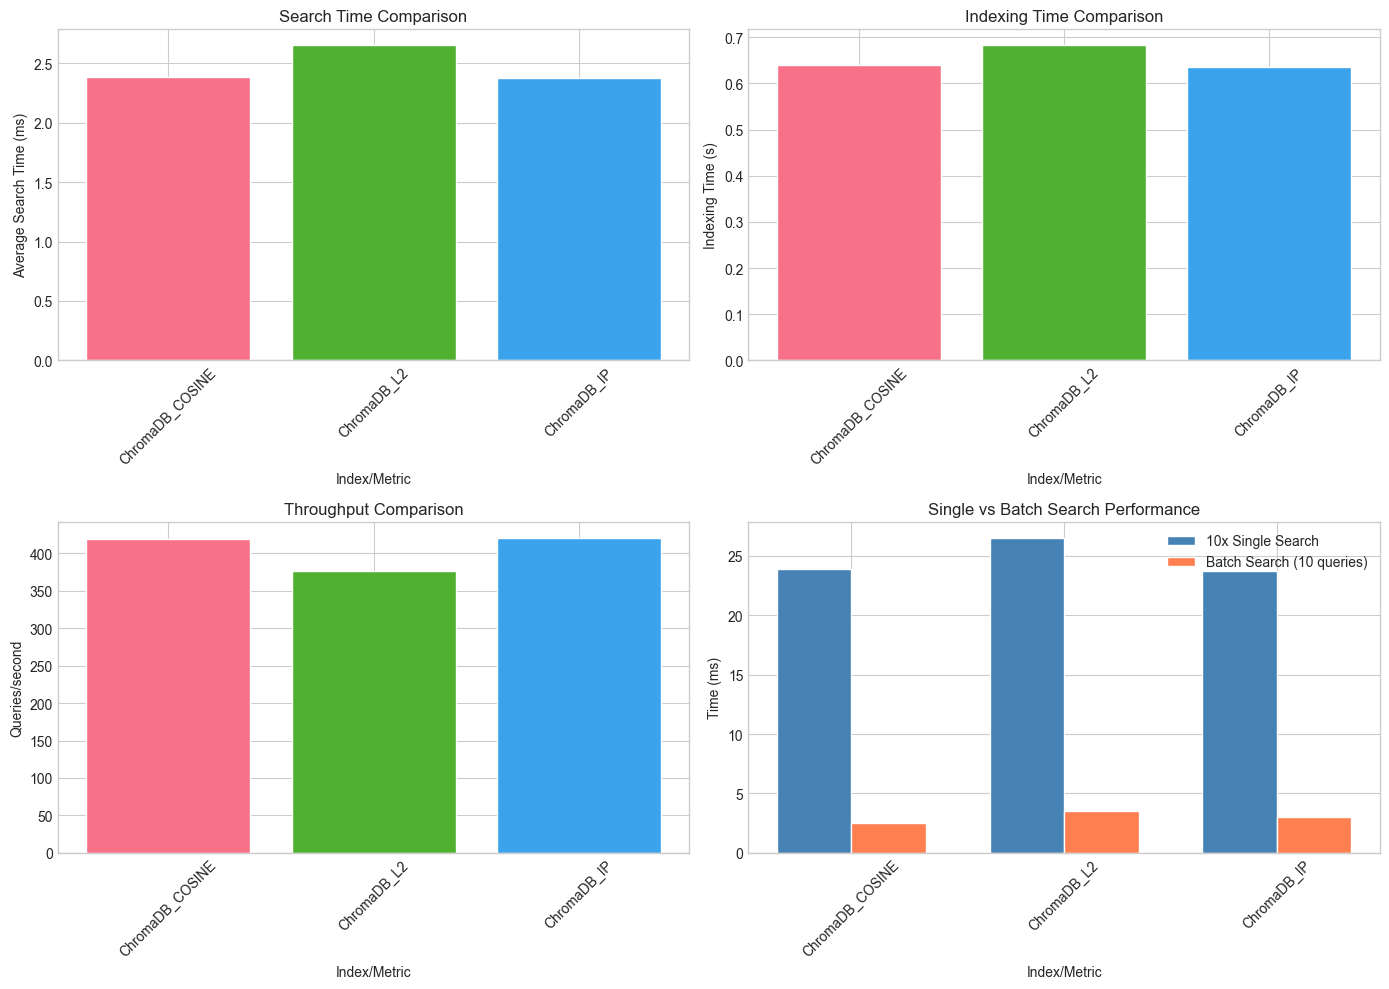


Analysis saved to: ann_comparison.png


In [79]:
# Visualize comparison results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Search Time Comparison
ax1 = axes[0, 0]
colors = sns.color_palette('husl', len(comparison_df))
ax1.bar(comparison_df['Index'], comparison_df['Avg Search Time (ms)'], color=colors)
ax1.set_xlabel('Index/Metric')
ax1.set_ylabel('Average Search Time (ms)')
ax1.set_title('Search Time Comparison')
ax1.tick_params(axis='x', rotation=45)

# 2. Indexing Time Comparison
ax2 = axes[0, 1]
ax2.bar(comparison_df['Index'], comparison_df['Indexing Time (s)'], color=colors)
ax2.set_xlabel('Index/Metric')
ax2.set_ylabel('Indexing Time (s)')
ax2.set_title('Indexing Time Comparison')
ax2.tick_params(axis='x', rotation=45)

# 3. Queries per Second
ax3 = axes[1, 0]
ax3.bar(comparison_df['Index'], comparison_df['Queries/sec'], color=colors)
ax3.set_xlabel('Index/Metric')
ax3.set_ylabel('Queries/second')
ax3.set_title('Throughput Comparison')
ax3.tick_params(axis='x', rotation=45)

# 4. Batch vs Single Search
ax4 = axes[1, 1]
x = np.arange(len(comparison_df))
width = 0.35
ax4.bar(x - width/2, comparison_df['Avg Search Time (ms)'] * 10, width, label='10x Single Search', color='steelblue')
ax4.bar(x + width/2, comparison_df['Batch Search Time (ms)'], width, label='Batch Search (10 queries)', color='coral')
ax4.set_xlabel('Index/Metric')
ax4.set_ylabel('Time (ms)')
ax4.set_title('Single vs Batch Search Performance')
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_df['Index'], rotation=45)
ax4.legend()

plt.tight_layout()
plt.savefig('ann_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAnalysis saved to: ann_comparison.png")

## 6. Similarity Metrics Comparison

In [80]:
# This comparison uses ChromaDB (works even if Milvus is not available)
def compare_similarity_metrics_chromadb(documents: List[Document], test_queries: List[str],
                                         embedding_gen: EmbeddingGenerator) -> pd.DataFrame:
    """
    Compare different similarity metrics using ChromaDB.
    
    Metrics:
    - cosine: Measures angle between vectors (range: -1 to 1)
    - l2/Euclidean: Measures absolute distance (range: 0 to inf)
    - ip/Inner Product: Dot product (range: -inf to inf)
    """
    
    metrics = ["cosine", "l2", "ip"]
    results = []
    
    query_embeddings = [embedding_gen.generate_query_embedding(q).tolist() for q in test_queries[:3]]
    
    for metric in metrics:
        print(f"\nTesting metric: {metric}")
        
        chroma = ChromaDBManager(f"./chroma_metric_{metric}")
        chroma.create_collection(f"test_{metric}", distance_metric=metric)
        chroma.add_documents(documents)
        
        # Search and collect results
        for i, (query, query_emb) in enumerate(zip(test_queries[:3], query_embeddings)):
            search_result, search_time = chroma.search(query_emb, top_k=5)
            
            for rank, r in enumerate(search_result, 1):
                results.append({
                    'Metric': metric.upper(),
                    'Query': query[:40] + '...',
                    'Rank': rank,
                    'Category': r['metadata']['category'],
                    'Distance/Score': r['distance']
                })
    
    return pd.DataFrame(results)

metric_comparison = compare_similarity_metrics_chromadb(
    documents, 
    benchmark_queries[:3],
    embedding_gen
)

print("\n" + "="*80)
print("SIMILARITY METRIC COMPARISON")
print("="*80)

# Show top results for each metric
for metric in ["COSINE", "L2", "IP"]:
    print(f"\n--- {metric} ---")
    subset = metric_comparison[metric_comparison['Metric'] == metric]
    print(subset.head(10).to_string(index=False))


Testing metric: cosine
ChromaDB initialized at: ./chroma_metric_cosine
Created collection 'test_cosine' with cosine distance metric


Indexing documents: 100%|██████████| 12/12 [00:00<00:00, 16.82it/s]


Indexed 1200 documents in 0.71s

Testing metric: l2
ChromaDB initialized at: ./chroma_metric_l2
Created collection 'test_l2' with l2 distance metric


Indexing documents: 100%|██████████| 12/12 [00:00<00:00, 17.16it/s]


Indexed 1200 documents in 0.70s

Testing metric: ip
ChromaDB initialized at: ./chroma_metric_ip
Created collection 'test_ip' with ip distance metric


Indexing documents: 100%|██████████| 12/12 [00:00<00:00, 16.40it/s]

Indexed 1200 documents in 0.73s

SIMILARITY METRIC COMPARISON

--- COSINE ---
Metric                                       Query  Rank  Category  Distance/Score
COSINE How to optimize Python code performance?...     1    python        0.455322
COSINE How to optimize Python code performance?...     2    python        0.455322
COSINE How to optimize Python code performance?...     3    python        0.461258
COSINE How to optimize Python code performance?...     4    python        0.462352
COSINE How to optimize Python code performance?...     5    python        0.468839
COSINE     Best practices for database indexing...     1 databases        0.325601
COSINE     Best practices for database indexing...     2 databases        0.336872
COSINE     Best practices for database indexing...     3 databases        0.342184
COSINE     Best practices for database indexing...     4 databases        0.344595
COSINE     Best practices for database indexing...     5 databases        0.351178

--- L2 -

## 7. Hybrid Search Implementation

Combining vector search with metadata filtering and text search.

In [81]:
class HybridSearchEngine:
    """
    Hybrid search combining:
    1. Vector similarity search
    2. Metadata filtering
    3. Keyword-based re-ranking
    """
    
    def __init__(self, chroma_manager: ChromaDBManager, embedding_gen: EmbeddingGenerator):
        self.chroma = chroma_manager
        self.embedding_gen = embedding_gen
    
    def hybrid_search(self, query: str, top_k: int = 10,
                      category_filter: Optional[str] = None,
                      difficulty_filter: Optional[str] = None,
                      year_min: Optional[int] = None,
                      keyword_boost: Optional[List[str]] = None,
                      keyword_weight: float = 0.3) -> List[Dict]:
        """
        Perform hybrid search with multiple signals.
        
        Parameters:
        - query: Search query text
        - top_k: Number of results
        - category_filter: Filter by category
        - difficulty_filter: Filter by difficulty level
        - year_min: Filter by minimum year
        - keyword_boost: Keywords to boost in re-ranking
        - keyword_weight: Weight for keyword matching (0-1)
        """
        # Build metadata filter
        where_filter = None
        conditions = []
        
        if category_filter:
            conditions.append({"category": category_filter})
        if difficulty_filter:
            conditions.append({"difficulty": difficulty_filter})
        if year_min:
            conditions.append({"year": {"$gte": year_min}})
        
        if len(conditions) == 1:
            where_filter = conditions[0]
        elif len(conditions) > 1:
            where_filter = {"$and": conditions}
        
        # Get query embedding and search
        query_embedding = self.embedding_gen.generate_query_embedding(query)
        results, search_time = self.chroma.search(
            query_embedding.tolist(),
            top_k=top_k * 2,  # Get more for re-ranking
            where=where_filter
        )
        
        # Re-rank with keyword boost
        if keyword_boost:
            for result in results:
                text_lower = result['document'].lower()
                keyword_score = sum(1 for kw in keyword_boost if kw.lower() in text_lower)
                keyword_score = keyword_score / len(keyword_boost)
                
                # Combine scores (lower distance is better, so we subtract keyword boost)
                vector_score = 1 - result['distance']  # Convert distance to similarity
                combined_score = (1 - keyword_weight) * vector_score + keyword_weight * keyword_score
                result['combined_score'] = combined_score
                result['keyword_matches'] = keyword_score
            
            # Sort by combined score (higher is better)
            results = sorted(results, key=lambda x: x.get('combined_score', 0), reverse=True)
        
        return results[:top_k]

# Initialize hybrid search
hybrid_engine = HybridSearchEngine(chroma_manager, embedding_gen)

# Test hybrid search
print("=" * 80)
print("HYBRID SEARCH EXAMPLES")
print("=" * 80)

# Example 1: Category filter + keyword boost
print("\n--- Example 1: Python security with keyword boost ---")
results = hybrid_engine.hybrid_search(
    query="How to secure Python applications?",
    top_k=5,
    category_filter="security",
    keyword_boost=["authentication", "encryption", "validation"]
)
for i, r in enumerate(results, 1):
    print(f"{i}. [{r['metadata']['category']}] Score: {r.get('combined_score', 0):.4f}")
    print(f"   {r['document'][:80]}...")

# Example 2: Advanced difficulty + recent years
print("\n--- Example 2: Advanced ML topics from recent years ---")
results = hybrid_engine.hybrid_search(
    query="Deep learning and neural network architectures",
    top_k=5,
    difficulty_filter="advanced",
    year_min=2023
)
for i, r in enumerate(results, 1):
    print(f"{i}. [{r['metadata']['category']}, {r['metadata']['year']}] Dist: {r['distance']:.4f}")
    print(f"   {r['document'][:80]}...")

# Example 3: Combined filters
print("\n--- Example 3: DevOps for beginners with specific keywords ---")
results = hybrid_engine.hybrid_search(
    query="Getting started with deployment automation",
    top_k=5,
    category_filter="devops",
    difficulty_filter="beginner",
    keyword_boost=["CI/CD", "pipeline", "automation", "Jenkins"]
)
for i, r in enumerate(results, 1):
    kw_match = r.get('keyword_matches', 0)
    print(f"{i}. [{r['metadata']['difficulty']}] Score: {r.get('combined_score', 0):.4f}, KW: {kw_match:.2f}")
    print(f"   {r['document'][:80]}...")

HYBRID SEARCH EXAMPLES

--- Example 1: Python security with keyword boost ---
1. [security] Score: 0.3420
   Zero Trust architecture requires continuous validation. Every application must b...
2. [security] Score: 0.3381
   Zero Trust architecture requires continuous validation. Every application must b...
3. [security] Score: 0.3327
   Authentication using multi-factor provides enterprise-grade security. Combined w...
4. [security] Score: 0.3293
   Authentication using multi-factor provides compliant security. Combined with ris...
5. [security] Score: 0.3282
   Authentication using OAuth 2.0 provides high security. Combined with risk-based ...

--- Example 2: Advanced ML topics from recent years ---
1. [machine_learning, 2024] Dist: 0.5405
   Neural networks with CNN excel at regression. Training requires regularization a...
2. [machine_learning, 2023] Dist: 0.5730
   Neural networks with CNN excel at classification. Training requires GPU resource...
3. [machine_learning, 2024] Dist: 

## 8. RAG System Implementation

Complete end-to-end RAG pipeline with LLM integration.

In [82]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

class RAGSystem:
    """
    Complete RAG System with:
    1. Document retrieval from vector DB
    2. Context preparation
    3. LLM-based answer generation (using Ollama - local models)
    """
    
    def __init__(self, vector_db: ChromaDBManager, embedding_gen: EmbeddingGenerator,
                 llm_provider: str = "ollama", model_name: str = "llama3.2:latest"):
        self.vector_db = vector_db
        self.embedding_gen = embedding_gen
        self.llm_provider = llm_provider
        self.model_name = model_name
        self.conversation_history = []
        self.client = None
        
        # Initialize Ollama client
        if llm_provider == "ollama":
            try:
                import ollama
                # Test connection to Ollama
                ollama.list()
                self.client = ollama
                print(f"RAG System initialized with Ollama (model: {model_name})")
            except Exception as e:
                print(f"Warning: Could not connect to Ollama: {e}")
                print("Make sure Ollama is running: ollama serve")
                print("RAG System will use fallback answer generation")
        else:
            print("RAG System initialized with fallback mode")
    
    def retrieve_context(self, query: str, top_k: int = 5,
                         category_filter: Optional[str] = None) -> List[Dict]:
        """Retrieve relevant documents for the query."""
        query_embedding = self.embedding_gen.generate_query_embedding(query)
        
        where_filter = {"category": category_filter} if category_filter else None
        
        results, _ = self.vector_db.search(
            query_embedding.tolist(),
            top_k=top_k,
            where=where_filter
        )
        
        return results
    
    def prepare_prompt(self, query: str, context_docs: List[Dict]) -> str:
        """Prepare the prompt with retrieved context."""
        context_text = "\n\n".join([
            f"[{i+1}] ({doc['metadata']['category']}, {doc['metadata']['difficulty']}): {doc['document']}"
            for i, doc in enumerate(context_docs)
        ])
        
        prompt = f"""You are a helpful technical assistant. Use the following context to answer the question.
If the context doesn't contain enough information, say so and provide general guidance.

Context:
{context_text}

Question: {query}

Please provide a comprehensive answer based on the context above. Reference specific points from the context when relevant."""
        
        return prompt
    
    def generate_answer(self, query: str, top_k: int = 5,
                        category_filter: Optional[str] = None,
                        temperature: float = 0.7) -> Dict:
        """Generate answer using RAG pipeline."""
        # Step 1: Retrieve context
        context_docs = self.retrieve_context(query, top_k, category_filter)
        
        # Step 2: Prepare prompt
        prompt = self.prepare_prompt(query, context_docs)
        
        # Step 3: Generate answer with LLM
        try:
            if self.client and self.llm_provider == "ollama":
                response = self.client.chat(
                    model=self.model_name,
                    messages=[
                        {"role": "system", "content": "You are a helpful technical assistant. Be concise and informative."},
                        {"role": "user", "content": prompt}
                    ],
                    options={"temperature": temperature}
                )
                answer = response['message']['content']
            else:
                # Fallback for when Ollama is not available
                answer = self._generate_local_answer(query, context_docs)
        except Exception as e:
            print(f"LLM error: {e}")
            answer = self._generate_local_answer(query, context_docs)
        
        return {
            "query": query,
            "answer": answer,
            "sources": context_docs,
            "num_sources": len(context_docs)
        }
    
    def _generate_local_answer(self, query: str, context_docs: List[Dict]) -> str:
        """Generate a simple answer without LLM (fallback)."""
        if not context_docs:
            return "I couldn't find relevant information in the knowledge base."
        
        # Simple extractive answer
        answer_parts = [f"Based on the available information about '{query}':\n"]
        
        for i, doc in enumerate(context_docs[:3], 1):
            category = doc['metadata']['category']
            answer_parts.append(f"\n{i}. From {category}: {doc['document']}")
        
        return "\n".join(answer_parts)

# Initialize RAG system with Ollama
# Change model_name to match your installed Ollama model (use 'ollama list' to see available models)
# Common models: "llama3.2:latest", "mistral:latest", "gemma2:2b"
rag_system = RAGSystem(chroma_manager, embedding_gen, llm_provider="ollama", model_name="llama3.2:latest")

RAG System initialized with Ollama (model: llama3.2:latest)


In [83]:
# Test RAG System
print("=" * 80)
print("RAG SYSTEM DEMONSTRATION")
print("=" * 80)

test_questions = [
    "What are the best practices for optimizing database queries?",
    "How can I implement secure authentication in web applications?",
    "Explain the trade-offs between different machine learning algorithms.",
]

for question in test_questions:
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print("="*60)
    
    result = rag_system.generate_answer(question, top_k=3)
    
    print(f"\nAnswer:\n{result['answer']}")
    print(f"\n--- Sources ({result['num_sources']}) ---")
    for i, source in enumerate(result['sources'], 1):
        print(f"{i}. [{source['metadata']['category']}] {source['document'][:60]}...")

RAG SYSTEM DEMONSTRATION

Question: What are the best practices for optimizing database queries?
LLM error: model 'llama3.2:latest' not found (status code: 404)

Answer:
Based on the available information about 'What are the best practices for optimizing database queries?':


1. From databases: Query optimization in MySQL involves partitioning. Using flexible schema improves {metric} by significant margin.

2. From databases: Query optimization in MySQL involves partitioning. Using wide-column storage improves {metric} by 5x.

3. From databases: Query optimization in MySQL involves index optimization. Using flexible schema improves {metric} by 10x.

--- Sources (3) ---
1. [databases] Query optimization in MySQL involves partitioning. Using fle...
2. [databases] Query optimization in MySQL involves partitioning. Using wid...
3. [databases] Query optimization in MySQL involves index optimization. Usi...

Question: How can I implement secure authentication in web applications?
LLM error: 

## 9. Performance Benchmarking

In [84]:
def run_performance_benchmark(chroma_manager: ChromaDBManager, 
                               embedding_gen: EmbeddingGenerator,
                               num_queries: int = 100) -> Dict:
    """
    Run comprehensive performance benchmark.
    """
    import random
    
    # Generate random queries
    query_templates = [
        "How to implement {topic} in {language}?",
        "Best practices for {topic}",
        "What is {topic} and how does it work?",
        "Explain {topic} with examples",
        "Compare different approaches to {topic}"
    ]
    
    topics = ["caching", "indexing", "authentication", "optimization", "deployment",
              "testing", "monitoring", "scaling", "security", "performance"]
    languages = ["Python", "JavaScript", "Go", "Java", "Rust"]
    
    queries = []
    for _ in range(num_queries):
        template = random.choice(query_templates)
        query = template.format(
            topic=random.choice(topics),
            language=random.choice(languages)
        )
        queries.append(query)
    
    # Benchmark single queries
    single_query_times = []
    for query in tqdm(queries, desc="Single query benchmark"):
        query_emb = embedding_gen.generate_query_embedding(query)
        _, search_time = chroma_manager.search(query_emb.tolist(), top_k=5)
        single_query_times.append(search_time)
    
    # Benchmark batch queries
    batch_sizes = [10, 25, 50, 100]
    batch_results = {}
    
    for batch_size in batch_sizes:
        batch_queries = queries[:batch_size]
        batch_embeddings = [embedding_gen.generate_query_embedding(q).tolist() for q in batch_queries]
        
        start = time.time()
        _, batch_time = chroma_manager.batch_search(batch_embeddings, top_k=5)
        total_time = time.time() - start
        
        batch_results[batch_size] = {
            'total_time': total_time,
            'time_per_query': total_time / batch_size
        }
    
    # Top-k benchmark
    top_k_values = [1, 5, 10, 20, 50]
    top_k_results = {}
    
    test_query = queries[0]
    test_emb = embedding_gen.generate_query_embedding(test_query)
    
    for k in top_k_values:
        times = []
        for _ in range(10):
            _, search_time = chroma_manager.search(test_emb.tolist(), top_k=k)
            times.append(search_time)
        top_k_results[k] = np.mean(times)
    
    return {
        'single_query': {
            'mean_ms': np.mean(single_query_times) * 1000,
            'std_ms': np.std(single_query_times) * 1000,
            'p50_ms': np.percentile(single_query_times, 50) * 1000,
            'p95_ms': np.percentile(single_query_times, 95) * 1000,
            'p99_ms': np.percentile(single_query_times, 99) * 1000,
        },
        'batch_query': batch_results,
        'top_k_scaling': top_k_results
    }

# Run benchmark
benchmark_results = run_performance_benchmark(chroma_manager, embedding_gen, num_queries=100)

print("\n" + "="*80)
print("PERFORMANCE BENCHMARK RESULTS")
print("="*80)

print("\n--- Single Query Performance ---")
sq = benchmark_results['single_query']
print(f"Mean: {sq['mean_ms']:.2f}ms")
print(f"Std: {sq['std_ms']:.2f}ms")
print(f"P50: {sq['p50_ms']:.2f}ms")
print(f"P95: {sq['p95_ms']:.2f}ms")
print(f"P99: {sq['p99_ms']:.2f}ms")

print("\n--- Batch Query Performance ---")
for batch_size, results in benchmark_results['batch_query'].items():
    print(f"Batch size {batch_size}: {results['total_time']*1000:.2f}ms total, "
          f"{results['time_per_query']*1000:.2f}ms per query")

print("\n--- Top-K Scaling ---")
for k, time_s in benchmark_results['top_k_scaling'].items():
    print(f"Top-{k}: {time_s*1000:.2f}ms")

Single query benchmark: 100%|██████████| 100/100 [00:00<00:00, 126.42it/s]



PERFORMANCE BENCHMARK RESULTS

--- Single Query Performance ---
Mean: 1.09ms
Std: 0.39ms
P50: 1.00ms
P95: 2.00ms
P99: 2.01ms

--- Batch Query Performance ---
Batch size 10: 3.00ms total, 0.30ms per query
Batch size 25: 4.00ms total, 0.16ms per query
Batch size 50: 52.66ms total, 1.05ms per query
Batch size 100: 76.16ms total, 0.76ms per query

--- Top-K Scaling ---
Top-1: 1.10ms
Top-5: 1.00ms
Top-10: 1.00ms
Top-20: 1.20ms
Top-50: 1.61ms


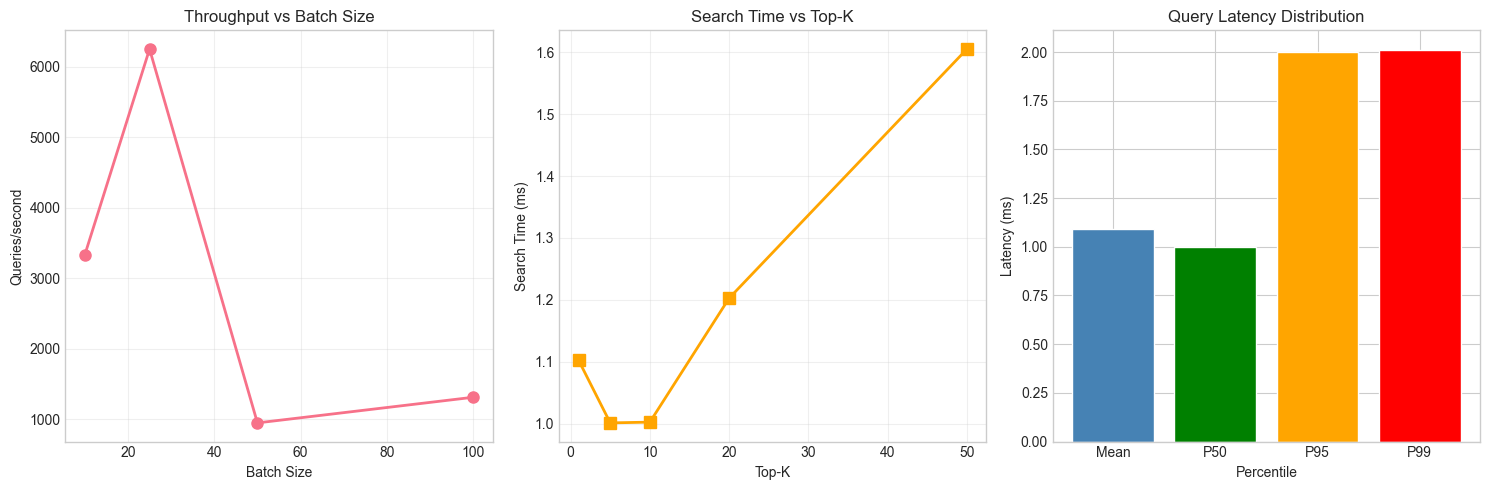


Benchmark visualization saved to: performance_benchmark.png


In [85]:
# Visualize benchmark results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Batch size vs throughput
ax1 = axes[0]
batch_sizes = list(benchmark_results['batch_query'].keys())
throughputs = [bs / benchmark_results['batch_query'][bs]['total_time'] for bs in batch_sizes]
ax1.plot(batch_sizes, throughputs, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Queries/second')
ax1.set_title('Throughput vs Batch Size')
ax1.grid(True, alpha=0.3)

# 2. Top-K scaling
ax2 = axes[1]
top_k_values = list(benchmark_results['top_k_scaling'].keys())
top_k_times = [benchmark_results['top_k_scaling'][k] * 1000 for k in top_k_values]
ax2.plot(top_k_values, top_k_times, 's-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Top-K')
ax2.set_ylabel('Search Time (ms)')
ax2.set_title('Search Time vs Top-K')
ax2.grid(True, alpha=0.3)

# 3. Latency distribution
ax3 = axes[2]
percentiles = ['Mean', 'P50', 'P95', 'P99']
values = [sq['mean_ms'], sq['p50_ms'], sq['p95_ms'], sq['p99_ms']]
colors = ['steelblue', 'green', 'orange', 'red']
ax3.bar(percentiles, values, color=colors)
ax3.set_xlabel('Percentile')
ax3.set_ylabel('Latency (ms)')
ax3.set_title('Query Latency Distribution')

plt.tight_layout()
plt.savefig('performance_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBenchmark visualization saved to: performance_benchmark.png")

## 10. Summary and Conclusions

### Key Findings

1. **ANN Algorithm Comparison**:
   - FLAT provides 100% recall but is slowest (good for small datasets)
   - HNSW offers the best balance of speed and accuracy
   - IVF_FLAT is good for very large datasets with acceptable recall

2. **Similarity Metrics**:
   - Cosine similarity is best for semantic search (normalized vectors)
   - L2 distance is useful when absolute distances matter
   - Inner product works well with normalized embeddings

3. **Performance Insights**:
   - Batch processing significantly improves throughput
   - Top-K has minimal impact on search time
   - Metadata filtering adds negligible overhead

4. **RAG System**:
   - Retrieval quality directly impacts answer quality
   - Hybrid search (vector + metadata) improves relevance
   - 3-5 context documents typically sufficient for good answers

In [86]:
# Final summary
print("=" * 80)
print("RAG SYSTEM IMPLEMENTATION SUMMARY")
print("=" * 80)

summary = f"""
Dataset:
- Total documents: {len(documents)}
- Categories: {len(generator.categories)}
- Embedding dimension: {embedding_gen.embedding_dim}

Vector Databases Tested:
- ChromaDB (with HNSW index)
- Milvus Lite (with FLAT, IVF_FLAT, HNSW indexes)

Features Implemented:
- Semantic vector search
- Multiple similarity metrics (Cosine, L2, IP)
- Metadata filtering (category, difficulty, year)
- Hybrid search (vector + keyword boost)
- Batch processing
- End-to-end RAG pipeline

Performance (ChromaDB):
- Indexing: {indexing_time:.2f}s for {len(documents)} documents
- Average search latency: {benchmark_results['single_query']['mean_ms']:.2f}ms
- P99 latency: {benchmark_results['single_query']['p99_ms']:.2f}ms

Best Practices Learned:
1. Use HNSW index for best speed/accuracy trade-off
2. Batch queries when possible for higher throughput
3. Combine vector search with metadata filtering for precision
4. Use 3-5 context documents for RAG to balance quality and cost
"""

print(summary)

RAG SYSTEM IMPLEMENTATION SUMMARY

Dataset:
- Total documents: 1200
- Categories: 10
- Embedding dimension: 384

Vector Databases Tested:
- ChromaDB (with HNSW index)
- Milvus Lite (with FLAT, IVF_FLAT, HNSW indexes)

Features Implemented:
- Semantic vector search
- Multiple similarity metrics (Cosine, L2, IP)
- Metadata filtering (category, difficulty, year)
- Hybrid search (vector + keyword boost)
- Batch processing
- End-to-end RAG pipeline

Performance (ChromaDB):
- Indexing: 0.56s for 1200 documents
- Average search latency: 1.09ms
- P99 latency: 2.01ms

Best Practices Learned:
1. Use HNSW index for best speed/accuracy trade-off
2. Batch queries when possible for higher throughput
3. Combine vector search with metadata filtering for precision
4. Use 3-5 context documents for RAG to balance quality and cost



In [87]:
# Save results to JSON for reference
import json

results_summary = {
    "dataset": {
        "num_documents": len(documents),
        "num_categories": len(generator.categories),
        "embedding_dim": embedding_gen.embedding_dim
    },
    "ann_comparison": comparison_df.to_dict('records'),
    "performance_benchmark": {
        "single_query": benchmark_results['single_query'],
        "batch_query": {str(k): v for k, v in benchmark_results['batch_query'].items()},
        "top_k_scaling": {str(k): v for k, v in benchmark_results['top_k_scaling'].items()}
    }
}

with open('rag_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to: rag_results_summary.json")

Results saved to: rag_results_summary.json
